In [ ]:
#Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import Librairies
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import os
import random 

import cv2

#Show image

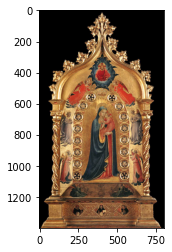

In [ ]:
img_dir="/content/drive/MyDrive/GANisme/src/img/00_madon.jpg"
img_plt = plt.imread(img_dir)
plt.imshow(img_plt)

In [ ]:
img_CV2 = cv2.imread(img_dir)

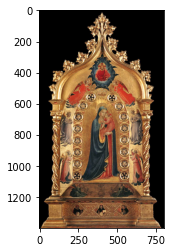

In [ ]:
new_img = cv2.cvtColor(img_CV2, cv2.COLOR_BGR2RGB)
plt.imshow(new_img)

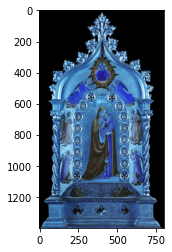

In [ ]:
plt.imshow(img_CV2)

In [ ]:
from PIL import Image
img_PIL = Image.open(img_dir)

In [ ]:
#img_PIL

In [ ]:
import os, os.path

# path joining version for other paths
DIR = '/content/drive/MyDrive/GANisme/src/img'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


7487


****** SHAPE = (1506, 1100, 3) ******
****** SIZE = 4969800 ******


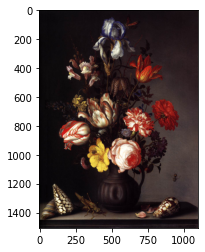

In [ ]:
path="/content/drive/MyDrive/GANisme/src/img/"
img_list=[]
files=os.listdir(path)

d=random.choice(files)
img_path = path + d
img_plt = plt.imread(img_path)
plt.imshow(img_plt)
img_list.append(img_plt.size)
print("****** SHAPE =",img_plt.shape, "******")
print("****** SIZE =",img_plt.size, "******")

In [ ]:
from os import listdir
from os.path import isfile, join
import re

In [ ]:
#parcourir le dossier et récupérer les images dans une liste 
fichiers = [f for f in listdir(path) if isfile(join(path, f))]
path="/content/drive/MyDrive/GANisme/src/img/"
files=os.listdir(path)

#reshape image par image 
for img_name in fichiers: 
  print(img_name)
  img_path = path + img_name
  #print(img_path)
  img = plt.imread(img_path)
  resized= cv2.resize(img, (400,400))

#upload resized image in a folder
  data = im.fromarray(resized)
  #print("data=", data)
  fp = open("/content/drive/MyDrive/GANisme/src/resized_img"+img_name , 'wb')
  fp.write(data)
  fp.close()
  #data.save()
  (print(fichiers.index(img_name)))

3ruccelz.jpg


TypeError: ignored

In [ ]:
#test resize + upload image dans in dossier 
from PIL import Image as im
image = "/content/drive/MyDrive/GANisme/src/img/00_madon.jpg"
img = cv2.imread(image)
image_resized= cv2.resize(img, (400,400))
data = im.fromarray(image_resized)

In [ ]:
data.save('/content/drive/MyDrive/GANisme/src/resized_img/test2.jpg')

FileNotFoundError: ignored

In [ ]:
data_plt = plt.imread(data)
plt.imshow(data_plt)
#data.save('/content/drive/MyDrive/GANisme/src/resized_img/')

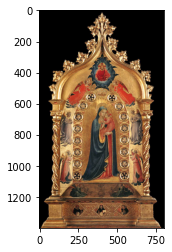

In [ ]:
#plt.imshow(img)
img_plt = plt.imread(image)
plt.imshow(img_plt)

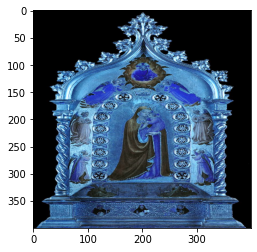

In [ ]:
plt.imshow(data)

In [ ]:
#img_CV2 = cv2.imread(resized)
data = Image.fromarray(resized[0])
data.save('/content/drive/MyDrive/GANisme/src/resized_img/test.jpg')

FileNotFoundError: ignored

In [ ]:
matrice_resized_image = np.array(resized_image)

In [ ]:
matrice_resized_image.shape

(7487, 400, 400, 3)

#Reshape

In [1]:
from os import listdir
from os.path import isfile, join
import re
from PIL import Image

In [ ]:
#parcourir le dossier et récupérer les images dans une liste 
path="/content/drive/MyDrive/GANisme/src/img/"
fichiers = [f for f in listdir(path) if isfile(join(path, f))]
files=os.listdir(path)

#reshape image par image 
for img_name in fichiers[0:50]: 
  img_path = path + img_name
  img = plt.imread(img_path)
  resized= cv2.resize(img, (400,400))
  resized_img = Image.fromarray(resized)
  resized_img.save("/content/drive/MyDrive/GANisme/src/resized_image/"+img_name)
  print(img_name)
  #fp = open("/content/drive/MyDrive/GANisme/src/resized_img"+img_name , 'wb')
  #fp.write(resized_img)
  #fp.close()

3ruccelz.jpg
4ruccel.jpg
4ruccela.jpg
4ruccelb.jpg
1buoncon.jpg
21badia.jpg
22gualin.jpg
23castel.jpg
24bologn.jpg
2crevola.jpg
2crevole.jpg
2crevolx.jpg
4bern.jpg
4metropo.jpg
51franci.jpg
52franci.jpg
6perugi.jpg
6perugia.jpg
7poly28.jpg
7poly28a.jpg
7poly28b.jpg
7poly28c.jpg
7poly28d.jpg
7poly28e.jpg
8london.jpg
8london1.jpg
8london2.jpg
8windsor.jpg
9boston1.jpg
9boston2.jpg
9crucifi.jpg
zpoly_47.jpg
zpoly_47a.jpg
zpoly_47b.jpg
zpoly_47c.jpg
zpoly_47d.jpg
dividing.jpg
guardint.jpg
guardrox.jpg
ladymaid.jpg
guardroo.jpg
notary1.jpg
selling.jpg
interiox.jpg
notary.jpg
kessel1.jpg
kessel2.jpg
versavel.jpg
2selfpor.jpg
dido.jpg


In [ ]:
resized.shape

(400, 400, 3)

In [ ]:
import pickle

In [ ]:
!mkdir '/content/drive/MyDrive/GANisme/src/pkl_img'

mkdir: cannot create directory ‘/content/drive/MyDrive/GANisme/src/pkl_img’: File exists


In [ ]:
pkl_img = '/content/drive/MyDrive/GANisme/src/pkl_img'
resized_img = '/content/drive/MyDrive/GANisme/src/resized_image/'
outfile = open(pkl_img,'wb')

In [ ]:
pickle.dump(resized_img,outfile)
outfile.close()

In [ ]:
outfile

<_io.BufferedWriter name='/content/drive/MyDrive/GANisme/src/pkl_img'>

In [ ]:
infile = open(pkl_img,'rb')
new_dict = pickle.load(infile)
infile.close()

In [ ]:
new_dict

'/content/drive/MyDrive/GANisme/src/resized_image/'

In [ ]:
print(new_dict)
print(new_dict==resized_img)
print(type(new_dict))

/content/drive/MyDrive/GANisme/src/resized_image/
True
<class 'str'>


#Model

In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/GANisme/src/resized_image/", 
    label_mode=None, image_size=(400,400),
     batch_size=32)

dataset = dataset.map(lambda x: x / 255.0)

Found 50 files belonging to 1 classes.


In [ ]:
dataset

<MapDataset element_spec=TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name=None)>

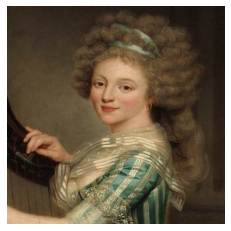

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

#Test model (64,64)

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 256)       0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=400):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 3  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history=gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/3


ValueError: ignored

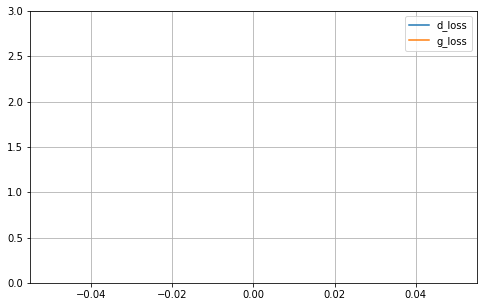

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-3]

plt.show()

#test model (128,128)

In [ ]:
import keras
from keras import layers
import numpy as np
latent_dim = 400
height = 32
width = 32
channels = 3

In [ ]:
#create discrminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(400,400, 3)),
        layers.Conv2D(200, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(100, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(50, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 200)     9800      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200, 200, 200)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 100)     320100    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100, 100, 100)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 50)        80050     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 50, 50, 50)        0         
                                                                 
 flatten (Flatten)           (None, 125000)          

In [ ]:
# create generator


generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(50 * 50 * 400),
        layers.Reshape((50, 50, 400)),
        layers.Conv2DTranspose(100, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(200, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(400, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1000000)           401000000 
                                                                 
 reshape (Reshape)           (None, 50, 50, 400)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 100, 100)    640100    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 100, 100, 100)     0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 200, 200, 200)    320200    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 200, 200, 200)     0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save('/content/drive/MyDrive/GANisme/model/generator.h5')
        self.model.discriminator.save('/content/drive/MyDrive/GANisme/model/discriminator.h5')
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #genere un fichier random
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255 #pour mettre l'image en bon format
        generated_images.numpy() # converti les images keras en numpy
#        for i in range(self.num_img):
#            img = keras.preprocessing.image.array_to_img(generated_images[i])
#            img.save("generated_img_%03d_%d.png" % (epoch, i)) # enregistre l'image dans le chemin donné

In [ ]:
epochs = 3  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])
#on a pas beosin d'enregistrer le model mais uniquement les poids
# pourquoi les callbacks, -> 

Epoch 1/3


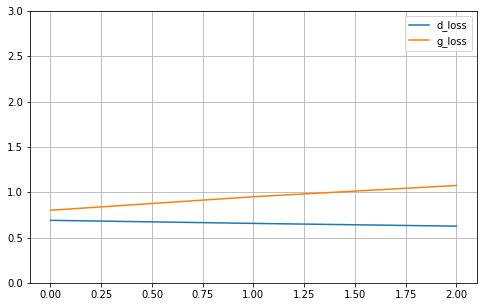

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-3]

plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/GANisme/model/generator.h5", custom_objects=None, compile=True, options=None)

In [ ]:
model.compile()

In [ ]:
batch_size = 20
latent_dim = 400
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
generated_images = model.predict(random_latent_vectors)

1/1 [==============================] - 15s 15s/step


In [ ]:
batch_size = 20
latent_dim = 400
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

In [ ]:
generated_images = model.predict(random_latent_vectors)

1/1 [==============================] - 14s 14s/step


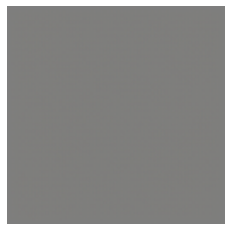

In [ ]:
plt.axis("off")
plt.imshow((generated_images*255).astype("int32")[0])